# Solving heat-driven incompressible flow with adaptive mixed finite elements in FEniCS

This Jupyter notebook shows how to solve the lid-driven cavity benchmark for incompressible flow by solving the Navier-Stokes equations using mixed finite elements in FEniCS [1] with goal-oriented adaptive mesh refinement (AMR).

|Nomenclature||
|------------|-|
|$\mathbf{x}$| point in the spatial domain|
|$t$| time |
|$p = p(\mathbf{x},t)$| pressure field |
|$\mathbf{u} = \mathbf{u}(\mathbf{x},t)$| velocity vector field |
|$T = T(\mathbf{x},t)$| temperature field |
|$()_t = \frac{\partial}{\partial t}()$| time derivative |
|$\mu$| constant dynamic viscosity of the fluid|
|$\mathbf{f}_B(T)$| temperature-dependent buoyancy force|
|$\mathrm{Ra}$ | Rayleigh number|
|$\mathrm{Pr}$ | Prandtl number|
|$\Omega$| spatial domain |
|$\mathbf{w} = \begin{pmatrix} p \\ \mathbf{u} \\ T \end{pmatrix}$| system solution|
|$\mathbf{W}$| mixed finite element function space |
|$\boldsymbol{\psi} = \begin{pmatrix} \psi_p \\ \boldsymbol{\psi}_u \\ \psi_T \end{pmatrix} $| mixed finite element basis functions|
|$\gamma$| penalty method stabilization parameter|
|$T_h$| hot boundary temperature |
|$T_c$| cold boundary temperature |
|$\Delta t$| time step size |
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## The Navier-Stokes-Boussinesq equations for heat-driven incompressible flow

The unsteady incompressible Navier-Stokes-Boussinesq equations can be written, scaled for unit Reynolds Number [4], as

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0  \\
    \mathbf{u}_t + \left( \mathbf{u}\cdot\nabla \right)\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathbf{D}(\mathbf{u}) + \mathbf{f}_B(T) &= 0  \\
    T_t + \mathbf{u}\cdot\nabla T - \frac{1}{\mathrm{Pr}}\Delta T &= 0
\end{align*}

where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor.

## Python packages

Import the Python packages for use in this notebook.

We need the finite element method library FEniCS.

In [1]:
import fenics


/opt/miniconda3/envs/fenicsproject/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


|Note|
|----|
| This Jupyter notebook server is using FEniCS 2017.2.0 from ppa:fenics-packages/fenics, installed via `apt` on Ubuntu 16.04.|

FEniCS has convenient plotting features that don't require us to import `matplotlib`; but using `matplotlib` directly will allow us to annotate the plots.

In [2]:
import matplotlib


Tell this notebook to embed graphical outputs from `matplotlib`, includings those made by `fenics.plot`.

In [3]:
%matplotlib inline


## Coarse mesh

Now, define a coarse mesh on the unit square.

In [ ]:
# mesh = fenics.UnitSquareMesh(N, N)
# 1. Initialize empty mesh
mesh = fenics.Mesh()
# 2. Open the XDMF file (must be in the same directory)
with fenics.XDMFFile("../plume_code/trig/air_mesh.xdmf") as infile:
    infile.read(mesh)
mvc = fenics.MeshValueCollection("size_t", mesh, 1)
# 4. Initialize the MeshFunction for boundaries
# This assumes your mesh file has 2D facets
with fenics.XDMFFile("../plume_code/trig/air_mesh.xdmf") as infile:
    infile.read(mvc, "Grid")
mf = fenics.cpp.mesh.MeshFunctionSizet(mesh, mvc)
domains = fenics.MeshFunction("size_t", mesh, mesh.topology().dim())
dx = fenics.Measure("dx",domain=mesh, subdomain_data=mf)
boundary_markers = fenics.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)


Let's look at the mesh.

Text(0, 0.5, '$y$')

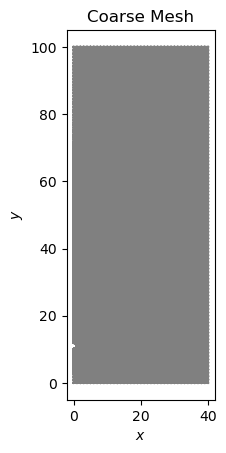

In [5]:
fenics.plot(mesh)

matplotlib.pyplot.title("Coarse Mesh")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")


## Mixed finite element function space, test functions, and solution functions

Make the mixed finite element. We choose pressure and velocity subspaces analagous to the Taylor-Hood (i.e. P2P1) mixed element [2], but we extend this further with a P1 element for the temperature.

In [6]:
P1 = fenics.FiniteElement('P', mesh.ufl_cell(), 1)

P2 = fenics.VectorElement('P', mesh.ufl_cell(), 2)

mixed_element = fenics.MixedElement([P1, P2, P1])


|Note|
|----|
|`fenics.FiniteElement` requires the `mesh.ufl_cell()` argument to determine some aspects of the domain (e.g. that the spatial domain is two-dimensional).|

Make the mixed finite element function space $\mathbf{W}$, which enumerates the mixed element basis functions on each cell of the mesh.

In [7]:
W = fenics.FunctionSpace(mesh, mixed_element)


Make the test functions $\psi_p$, $\boldsymbol{\psi}_u$, and $\psi_T$.

In [8]:
psi_p, psi_u, psi_T = fenics.TestFunctions(W)


Make the system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}$, and $T$.

In [9]:
w = fenics.Function(W)

p, u, T = fenics.split(w)


### Benchmark parameters

Set constant dynamic viscosity, Prandtl number, and Rayleigh number for the natural convection benchmark in [5]. For each we define a `fenics.Constant` for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [10]:
dynamic_viscosity = 1.

mu = fenics.Constant(dynamic_viscosity)

prandtl_number = 0.71

Pr = fenics.Constant(prandtl_number)

rayleigh_number = 10

Ra = fenics.Constant(rayleigh_number)


Define the idealized linear Boussinesq buoyancy, scaled according to [5],

\begin{align*}
\mathbf{f}_B(T) = \frac{\mathrm{Ra}}{\mathrm{Pr}} T\begin{pmatrix} 0 \\ -1 \end{pmatrix}.
\end{align*}

In [11]:
f_B = Ra/Pr*T*fenics.Constant((0., -1.))


Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively.

In [12]:
hot_wall_temperature = 1.0

T_h = fenics.Constant(hot_wall_temperature)

cold_wall_temperature = 0.0

T_c = fenics.Constant(cold_wall_temperature)


### Time discretization

We are solving an initial value problem. We will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations. For this we consider the initial values

\begin{align*}
    p^0  = 0  \\
    \mathbf{u}^0 = \mathbf{0} \\
    T^0  = T_h + x_0(T_c - T_h)
\end{align*}

Interpolate these valuesto create the initial solution function.

In [13]:
# Create an XDMF file object
# with fenics.XDMFFile("/Users/mark/FEnics/Plume/trig/temperature.xdmf") as infile:
#     # Read the mesh
#     mesh1 = fenics.Mesh()
#     infile.read(mesh1)

#     # Define the function space
#     V11 = fenics.FunctionSpace(mesh1, "Lagrange", 1)

#     # Read the function into a new Function object
#     u = fenics.Function(V11)
#     mvc = fenics.MeshValueCollection("size_t", mesh1, 1)
#     infile.read(mvc, "Grid")
#     mf = fenics.cpp.mesh.MeshFunctionSizet(mesh1, mvc)
#     u = fenics.interpolate(mf, V11)


w_n = fenics.interpolate(
    fenics.Expression(("0.", "0.", "0.", "0."), 
                      # T_h = hot_wall_temperature, T_c = cold_wall_temperature,
                      element = mixed_element),
                        W)

p_n, u_n, T_n = fenics.split(w_n)

print(type(T_n))


<class 'ufl.indexed.Indexed'>


Let's look at the initial values now.

Object cannot be plotted directly, projecting to piecewise linears.


Text(0, 0.5, '$y$')

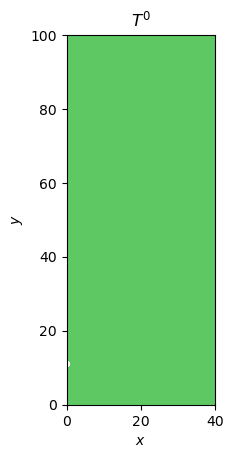

In [14]:
fenics.plot(T_n)

matplotlib.pyplot.title("$T^0$")

matplotlib.pyplot.xlabel("$x$")

matplotlib.pyplot.ylabel("$y$")


For the time derivative terms $\mathbf{u}_t$ and $T_t$, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*}
    \mathbf{u}_t = \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\
    T_t = \frac{T^{n+1} - T^n}{\Delta t}
\end{align*}

|Note|
|----|
|For our implementation, we will use the shorthand $\mathbf{w} = \mathbf{w}^{n+1}$|

Choose a time step size and set the time derivative terms.

In [15]:
timestep_size = 0.001

Delta_t = fenics.Constant(timestep_size)

u_t = (u - u_n)/Delta_t

T_t = (T - T_n)/Delta_t


## Nonlinear variational form

We can write the nonlinear system of equations as

\begin{align*}
\mathbf{F}(\mathbf{w}) = \mathbf{0}
\end{align*}

To obtain the finite element weak form, we follow the standard Ritz-Galerkin method extended for mixed finite elements. Therefore, we multiply the system  *from the left* by test functions $\boldsymbol{\psi}$ from the mixed finite element function space $\mathbf{W}$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find $\mathbf{w} \in \mathbf{W}$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = \int_\Omega 
    \boldsymbol{\psi}^\mathrm{T} \mathbf{F}(\mathbf{w}) 
    d\mathbf{x} = 0 \quad \forall \boldsymbol{\psi} \in \mathbf{W}
\end{align*}

Integrating $\mathcal{F}$ by parts yields
 
\begin{align*}
    \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = -(\psi_p,\nabla\cdot\mathbf{u}) \\
    + (\boldsymbol{\psi}_u, \mathbf{u}_t + \nabla\mathbf{u}\cdot\mathbf{u} + \mathbf{f}_B(T)) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathbf{D}(\boldsymbol{\psi}_u),\mathbf{D}(\mathbf{u})) \\
    + (\psi_T,T_t) + (\nabla \psi_T, \frac{1}{\mathrm{Pr}}\nabla T - T\mathbf{u})
\end{align*}

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|

Define the nonlinear variational form $\mathcal{F}$.

In [16]:
inner, dot, grad, div, sym = \
    fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
    
mass = -psi_p*div(u)

momentum = dot(psi_u, u_t + dot(grad(u), u) + f_B) - div(psi_u)*p \
    + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))

energy = psi_T*T_t + dot(grad(psi_T), 1./Pr*grad(T) - T*u)
        
F = (mass + momentum + energy)*fenics.dx


We add a penalty method stabilization term $-\gamma(\psi_p,p)$, setting the stabilization parameter $\gamma = 10^{-7}$ as done in [5].

|Note|
|----|
|One can solve the incompressible Navier-Stokes equation **either** with P2P1 elements, **or** with the penalty method and P1P1 elements. Neither of these approaches works alone when also coupling the temperature convection-diffusion equation with Boussinesq buoyancy; but applying both stabilization methods together does work.|

In [17]:
penalty_stabilization_parameter = 1.e-7

gamma = fenics.Constant(penalty_stabilization_parameter)

F += -psi_p*gamma*p*fenics.dx


## Linearization

Notice that $\mathcal{F}$ is a *nonlinear* variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

In [18]:
JF = fenics.derivative(F, w, fenics.TrialFunction(W))


|Note|
|----|
|When solving linear variational problems in FEniCS, one defines the linear variational form using `fenics.TrialFunction` instead of `fenics.Function` (while both approaches will need `fenics.TestFunction`). When solving nonlinear variational problems with FEniCS, we only need `fenics.TrialFunction` to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.|

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational *problem* (i.e. in this case a boundary value problem).

We physically consider *no slip* velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*}
    T(\mathbf{x}) &= 
    \begin{cases}
        T_h , && x_0 = 0 \\
        T_c , && x_0 = 1 
    \end{cases}
\end{align*}

In [19]:
# python class 

class Hot_wall(fenics.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fenics.near((x[0]**2)+((x[1]-11.)**2)-1., 0., eps= 1.e-1) and x[1] >= 10. and x[1] <= 12.
# hot_wall = " near((x[0]*x[0])+((x[1]-11.)*(x[1]-11.))-1., 0.)"
hot_wall=Hot_wall()

cold_wall = "near(x[0],  1.) | near(x[0], 0.) | near(x[1], 1.)"

adiabatic_walls = "near(x[1],  0.)"

# walls = hot_wall + " | " + cold_wall + " | " + adiabatic_walls


Define the boundary conditions on the appropriate subspaces.

In [20]:
W_u = W.sub(1)

W_T = W.sub(2)

boundary_conditions = [
    fenics.DirichletBC(W_u, (0., 0.), hot_wall),
    fenics.DirichletBC(W_T, hot_wall_temperature, hot_wall),
    fenics.DirichletBC(W_T, cold_wall_temperature, cold_wall)]


## Nonlinear variational problem

Now we have everything we need to define the variational problem.

In [21]:
problem = fenics.NonlinearVariationalProblem(F, w, boundary_conditions, JF)


## Goal-oriented adaptive mesh refinement (AMR)

We wish to solve the problem with adaptive mesh refinement (AMR) [3]. For this it helps to explain that we have already defined the *discrete* nonlinear variational problem using FEniCS: Find $\mathbf{w}_h \in \mathbf{W}_h \subset \mathbf{W}(\Omega)$ such that

\begin{align*}
    \mathcal{F}(\boldsymbol{\psi}_h;\mathbf{w}_h) = 0 \quad \forall \boldsymbol{\psi}_h \in \mathbf{W}_h \subset \mathbf{W}
\end{align*}

Given this, goal-oriented AMR poses the problem: Find $\mathbf{W}_h \subset \mathbf{W}(\Omega)$ and $\mathbf{w}_h \in \mathbf{W}_h$ such that

\begin{align*}
    \left| M(\mathbf{w}) - M(\mathbf{w}_h) \right| < \epsilon_M
\end{align*}

where $M$ is some goal functional of the solution which we integrate over the domain, and where $\epsilon_M$ is a prescribed tolerance. Note that since we do not know the exact solution $\mathbf{w}$, this method requires an error estimator. This is detailed in [3]. For our purposes, we only need to define $M$ and $\epsilon_M$.

We choose a goal involving the temperature gradient.

\begin{align*}
    M = \int_\Omega \nabla T : \nabla T d\mathbf{x}
\end{align*}

In [22]:
M = inner(grad(T), grad(T))*fenics.dx


Let's set the tolerance somewhat arbitrarily. For real problems of scientific or engineering interest, one might have accuracy requirements which could help drive this decision.

In [23]:
epsilon_M = 0.01


## The benchmark solution

Finally we instantiate the adaptive solver with our problem and goal

In [24]:
solver = fenics.NonlinearVariationalSolver(problem)


set the Newton solver's initial guess based on the initial values

In [25]:
w.leaf_node().vector()[:] = w_n.leaf_node().vector()


and solve the problem to the prescribed tolerance.

In [26]:
solver.solve()


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.659e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 4.864e-06 (tol = 1.000e-10) r (rel) = 6.350e-08 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 7.373e-15 (tol = 1.000e-10) r (rel) = 9.626e-17 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.


(2, True)

|Note|
|----|
|`solver.solve` will modify the solution `w`, which means that `u` and `p` will also be modified.|

Now plot the temperature field, velocity field, and adapted mesh.

Object cannot be plotted directly, projecting to piecewise linears.


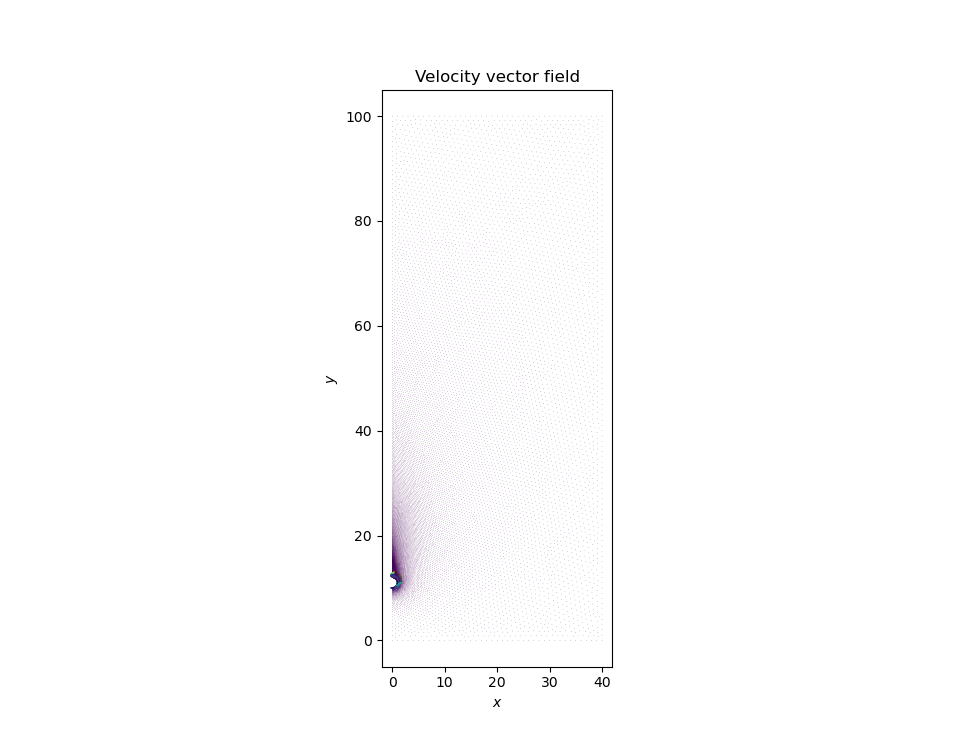

In [32]:
%matplotlib widget

from matplotlib import interactive
interactive(True)
def plot(w):
    
    p, u, T = fenics.split(w.leaf_node())
    
    
    # fenics.plot(T)

    # matplotlib.pyplot.title("Temperature field")

    # matplotlib.pyplot.xlabel("$x$")

    # matplotlib.pyplot.ylabel("$y$")
    
    # matplotlib.pyplot.show()

    # matplotlib.pyplot.cla()
    
    
    fenics.plot(u)

    matplotlib.pyplot.title("Velocity vector field")

    matplotlib.pyplot.xlabel("$x$")

    matplotlib.pyplot.ylabel("$y$")
    
    matplotlib.pyplot.show()

    
    # fenics.plot(w.leaf_node().function_space().mesh())

    # matplotlib.pyplot.title("Adapted mesh")

    # matplotlib.pyplot.xlabel("$x$")

    # matplotlib.pyplot.ylabel("$y$")
    
    # matplotlib.pyplot.show()
    
    
plot(w)


This benchmark is usually considered at steady state. To obtain an approximate steady state solution, take a series of increasingly large time steps.

|Note|
|----|
|For some problems it's possible to take one arbitrarily large time step to approximate the steady state solution. By beginning with smaller time steps, we're essentially providing more accurate initial guesses to the Newton solver.|

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.954e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.699e-06 (tol = 1.000e-10) r (rel) = 1.381e-06 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 8.244e-15 (tol = 1.000e-10) r (rel) = 4.220e-15 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.


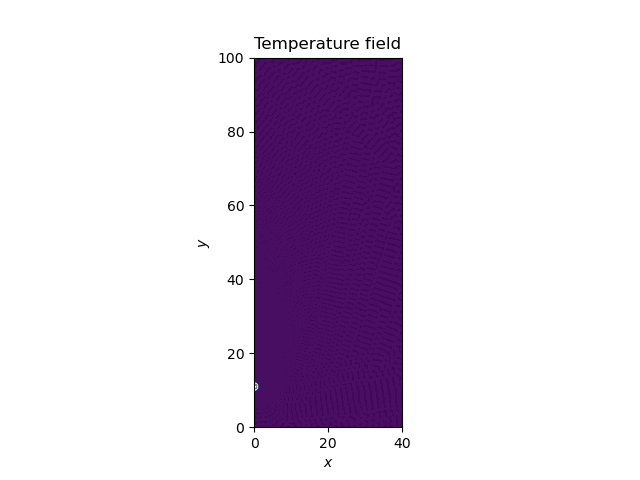

Object cannot be plotted directly, projecting to piecewise linears.


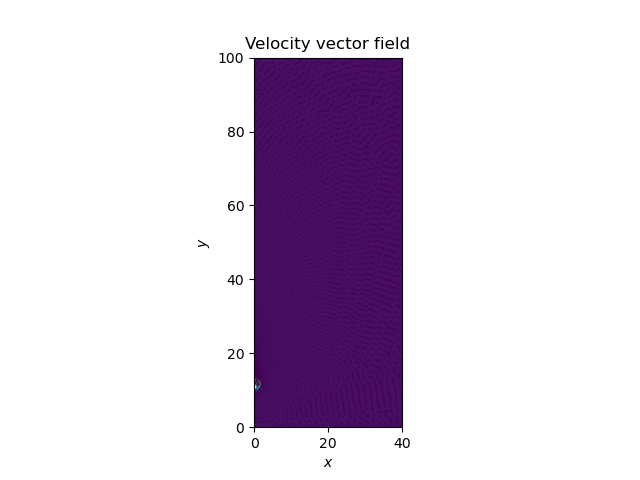

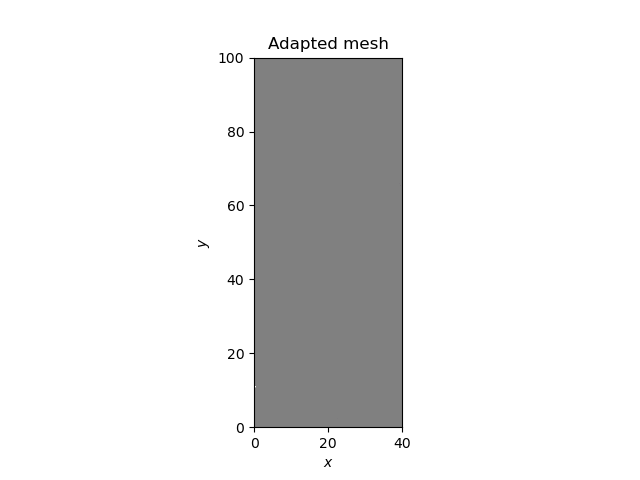

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.101e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.157e-06 (tol = 1.000e-10) r (rel) = 1.959e-06 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 8.929e-15 (tol = 1.000e-10) r (rel) = 8.110e-15 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.


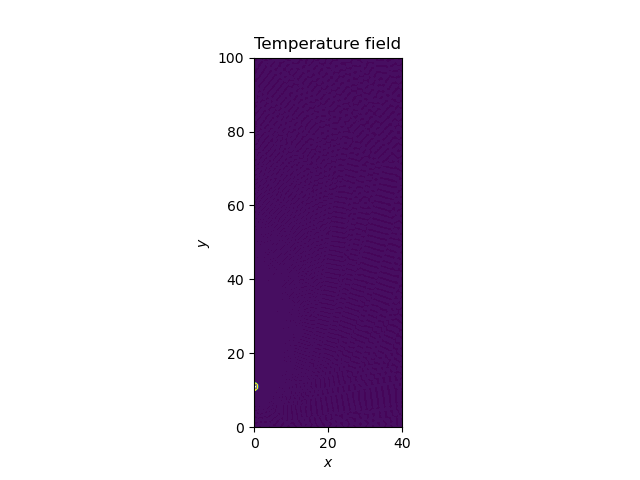

Object cannot be plotted directly, projecting to piecewise linears.


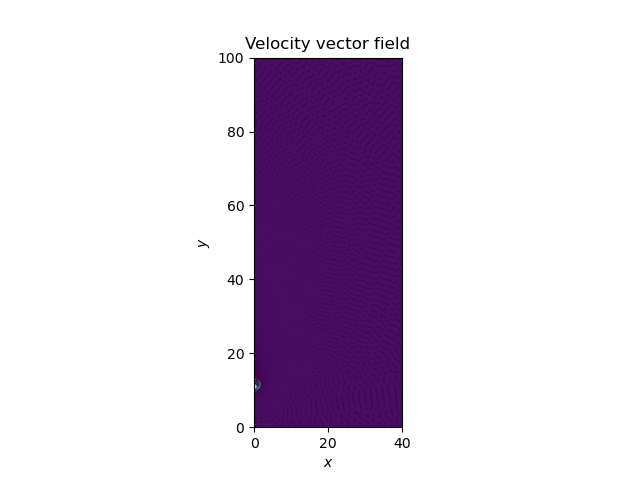

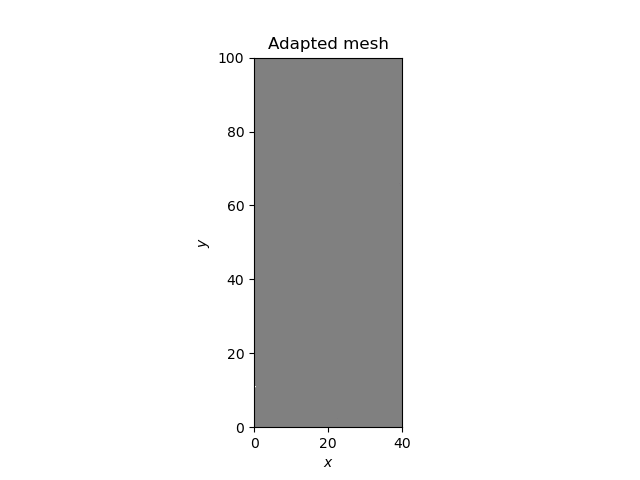

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 8.799e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.862e-06 (tol = 1.000e-10) r (rel) = 2.116e-06 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.308e-15 (tol = 1.000e-10) r (rel) = 1.058e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.


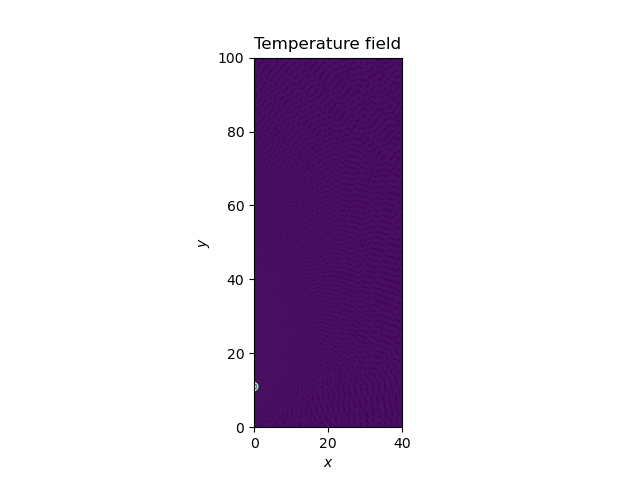

Object cannot be plotted directly, projecting to piecewise linears.


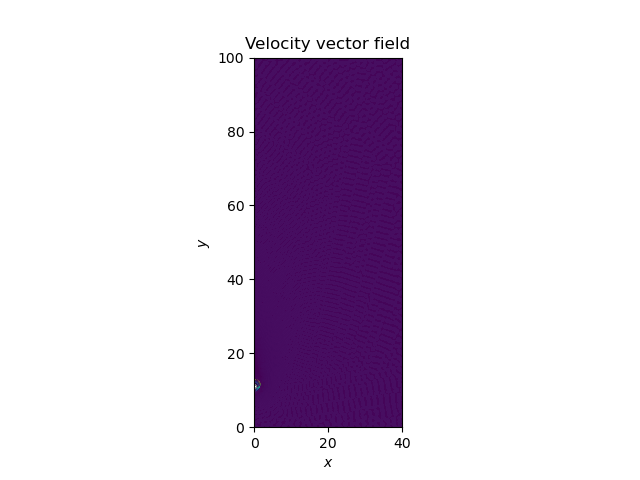

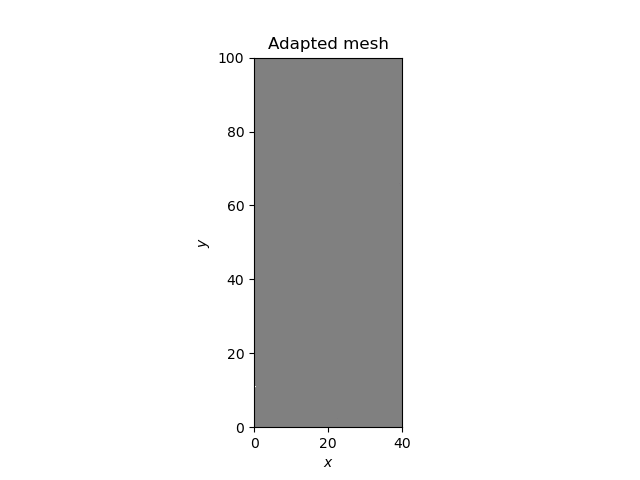

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 7.666e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.663e-06 (tol = 1.000e-10) r (rel) = 2.169e-06 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 9.456e-15 (tol = 1.000e-10) r (rel) = 1.233e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.


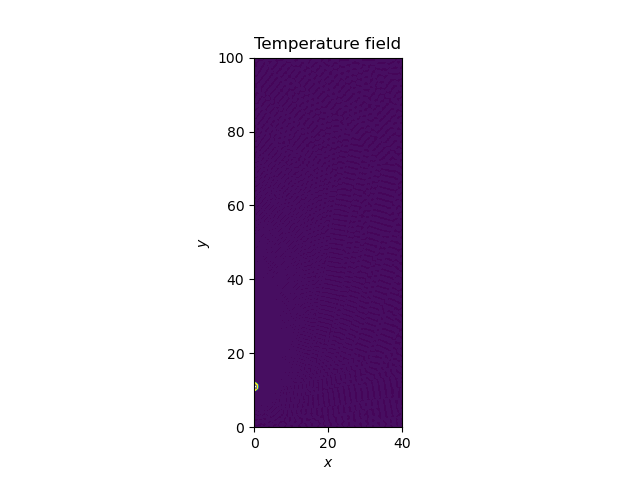

Object cannot be plotted directly, projecting to piecewise linears.


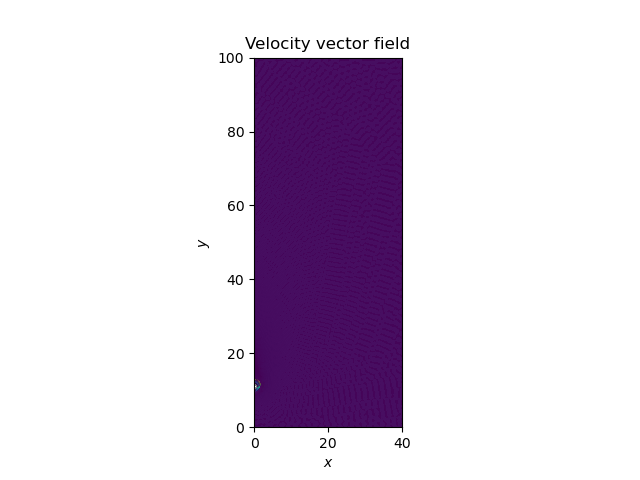

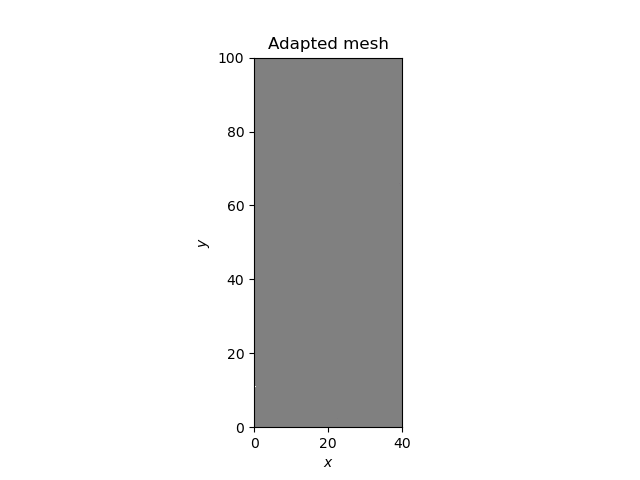

In [28]:
timestep_size = 1e-3
for timestep in range(4):
    
    w_n.leaf_node().vector()[:] = w.leaf_node().vector()
    
    
    Delta_t.assign(timestep_size)
    
    solver.solve()
    
    plot(w)


## References
[1] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[2] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003. 

[3] W Bangerth and R Rannacher. **Adaptive Finite Element Methods for Differential Equations**. *Springer Science & Business Media*, 2003.

[4] I Danaila, R Moglan, F Hecht, and S Le Masson. **A newton method with adaptive finite elements for solving phase-change problems with natural convection.** *Journal of Computational Physics*, 274:826–840, 2014.

[5] S Wang, A Faghri, and TL Bergman. **A comprehensive numerical model for melting with natural convection.** *International Journal of Heat and Mass Transfer*, 53(9):1986–2000, 2010.